Add imports, define hyperparameter variables and load the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

BATCH_SIZE = 128
LOOKBACK_LENGTH = 30
PREDICTION_LENGTH = 7
TEST_LENGTH = 365
DROPOUT = 0.2
DAY_SIZE = 3
MONTH_SIZE = 4
HIDDEN_SIZE = 256
NUM_LAYERS = 3
LEARNING_RATE = 0.001
EPOCHS = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and sort the data
data = pd.read_csv("../data/BTC Data 2013-12-27 2025-04-01.csv")
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

print(f"Data range: {data['date'].min()} to {data['date'].max()}")
print(f"Total samples: {len(data)}")

Using device: cuda
Data range: 2013-12-27 00:00:00 to 2025-04-01 00:00:00
Total samples: 4114


Feature engineer some extra features for monthly and weekly cyclic trends in the Bitcoin history.

In [2]:
data['dayOfWeek'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month - 1

Choose the features and targets. Normalize the dataset.

In [4]:
feature_columns = ['open', 'high', 'low', 'volume', 'dayOfWeek', 'month']
target_column = 'close'

X = data[feature_columns].values
y = data[target_column].values.reshape(-1, 1)

X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = X_scaler.fit_transform(X)
y_normalized = y_scaler.fit_transform(y)

Split the parameters into their own features.

In [5]:
X_open = X_normalized[:, [0]]
X_high = X_normalized[:, [1]]
X_low = X_normalized[:, [2]]
X_volume = X_normalized[:, [3]]
X_dayOfWeek = X[:, [4]]
X_month = X[:, [5]]

Create custom timeseries sequences.

In [6]:
class TimeSeriesDataset(Dataset):
	def __init__(self, X_open, X_high, X_low, X_volume, X_dayOfWeek, X_month, Y):
		self.X_open = torch.FloatTensor(X_open)
		self.X_high = torch.FloatTensor(X_high)
		self.X_low = torch.FloatTensor(X_low)
		self.X_volume = torch.FloatTensor(X_volume)
		self.X_dayOfWeek = torch.LongTensor(X_dayOfWeek)
		self.X_month = torch.LongTensor(X_month)
		self.Y = torch.FloatTensor(Y)

	def __len__(self):
		return len(self.X_open)

	def __getitem__(self, i):
		return (
			self.X_open[i],
			self.X_high[i],
			self.X_low[i],
			self.X_volume[i],
			self.X_dayOfWeek[i],
			self.X_month[i]
		), self.Y[i]

def create_X_sequences(X, history, prediction):
	X_seq = []
	
	for i in range(len(X) - history - prediction):
		X_seq.append(X[i:i + history])
	
	return np.array(X_seq)

def create_y_sequences(y, history, prediction):
	Y_seq = []
	
	for i in range(len(X) - history - prediction):
		Y_seq.append(y[i + history:i + history + prediction])
	
	return np.array(Y_seq)

X_open_seq = create_X_sequences(X_normalized[:, [0]], LOOKBACK_LENGTH, PREDICTION_LENGTH)
X_high_seq = create_X_sequences(X_normalized[:, [1]], LOOKBACK_LENGTH, PREDICTION_LENGTH)
X_low_seq = create_X_sequences(X_normalized[:, [2]], LOOKBACK_LENGTH, PREDICTION_LENGTH)
X_volume_seq = create_X_sequences(X_normalized[:, [3]], LOOKBACK_LENGTH, PREDICTION_LENGTH)
X_dayOfWeek_seq = create_X_sequences(X[:, [4]], LOOKBACK_LENGTH, PREDICTION_LENGTH)
X_month_seq = create_X_sequences(X[:, [5]], LOOKBACK_LENGTH, PREDICTION_LENGTH)

Y_seq = create_y_sequences(y_normalized, LOOKBACK_LENGTH, PREDICTION_LENGTH)

test_dates = data['date'].iloc[-TEST_LENGTH:]

Create the datasets for all different features.

In [7]:
train_X_open = X_open_seq[:-TEST_LENGTH]
train_X_high = X_high_seq[:-TEST_LENGTH]
train_X_low = X_low_seq[:-TEST_LENGTH]
train_X_volume = X_volume_seq[:-TEST_LENGTH]
train_X_dayOfWeek = X_dayOfWeek_seq[:-TEST_LENGTH]
train_X_month = X_month_seq[:-TEST_LENGTH]
train_Y = Y_seq[:-TEST_LENGTH]

test_X_open = X_open_seq[-TEST_LENGTH:]
test_X_high = X_high_seq[-TEST_LENGTH:]
test_X_low = X_low_seq[-TEST_LENGTH:]
test_X_volume = X_volume_seq[-TEST_LENGTH:]
test_X_dayOfWeek = X_dayOfWeek_seq[-TEST_LENGTH:]
test_X_month = X_month_seq[-TEST_LENGTH:]
test_Y = Y_seq[-TEST_LENGTH:]

train_dataset = TimeSeriesDataset(
	train_X_open, train_X_high, train_X_low, train_X_volume,
	train_X_dayOfWeek, train_X_month, train_Y
)
test_dataset = TimeSeriesDataset(
	test_X_open, test_X_high, test_X_low, test_X_volume,
	test_X_dayOfWeek, test_X_month, test_Y
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for X_batch, Y_batch in train_loader:
	print(f"Input shape: {X_batch[0].shape}")
	print(f"Output shape: {Y_batch.shape}")
	break

Input shape: torch.Size([128, 30, 1])
Output shape: torch.Size([128, 7, 1])


Create the encoder and decoder for the sequence to sequence model.

In [8]:
class Encoder(nn.Module):
	def __init__(self, input_size, day_input_size, month_input_size, hidden_size, num_layers, dropout):
		super(Encoder, self).__init__()

		self.open = nn.Linear(1, input_size)
		self.high = nn.Linear(1, input_size)
		self.low = nn.Linear(1, input_size)
		self.volume = nn.Linear(1, input_size)
		self.dayOfWeek = nn.Embedding(7, day_input_size)
		self.month = nn.Embedding(12, month_input_size)

		combined_input_size = input_size * 4 + day_input_size + month_input_size
		self.lstm = nn.LSTM(combined_input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)

	def forward(self, x):
		x_open, x_high, x_low, x_volume, x_dayofweek, x_month = x
		open = F.relu(self.open(x_open))
		high = F.relu(self.high(x_high))
		low = F.relu(self.low(x_low))
		volume = F.relu(self.volume(x_volume))

		x_dayofweek = x_dayofweek.squeeze(-1).long()
		x_month = x_month.squeeze(-1).long()

		day = self.dayOfWeek(x_dayofweek)
		month = self.month(x_month)

		features = torch.cat((open, high, low, volume, day, month), dim=2)

		_, (hidden, cell) = self.lstm(features)
		return hidden, cell
	
class Decoder(nn.Module):
	def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
		super(Decoder, self).__init__()

		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
		self.fc = nn.Linear(hidden_size, output_size)

	def forward(self, x, hidden, cell):
		output, (hidden, cell) = self.lstm(x, (hidden, cell))
		prediction = self.fc(output)

		return prediction, hidden, cell

Create the Sequence to Sequence model.

In [9]:
class Seq2SeqPrediction(nn.Module):
	def __init__(self, input_size, day_size, month_size, hidden_size, num_layers, dropout):
		super(Seq2SeqPrediction, self).__init__()

		self.encoder = Encoder(input_size, day_size, month_size, hidden_size, num_layers, dropout)
		self.decoder = Decoder(1, hidden_size, 1, num_layers, dropout)

	def forward(self, x, prediction_length):
		hidden, cell = self.encoder(x)

		decoder_input = torch.zeros(x[0].size(0), 1, 1)
		decoder_input = decoder_input.to(device)

		outputs = []

		for _ in range(prediction_length):
			decoder_output, hidden, cell = self.decoder(decoder_input, hidden, cell)
			outputs.append(decoder_output)
			decoder_input = decoder_output

		return torch.cat(outputs, dim=1)

model = Seq2SeqPrediction(len(feature_columns), DAY_SIZE, MONTH_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
model = model.to(device)
print(model)

Seq2SeqPrediction(
  (encoder): Encoder(
    (open): Linear(in_features=1, out_features=6, bias=True)
    (high): Linear(in_features=1, out_features=6, bias=True)
    (low): Linear(in_features=1, out_features=6, bias=True)
    (volume): Linear(in_features=1, out_features=6, bias=True)
    (dayOfWeek): Embedding(7, 3)
    (month): Embedding(12, 4)
    (lstm): LSTM(31, 256, num_layers=3, batch_first=True, dropout=0.2)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 256, num_layers=3, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=256, out_features=1, bias=True)
  )
)


Define loss function and Adam optimizer. Train the model. Make sure to always define the model with the code above before running.

In [10]:
def train(model, train_loader, criterion, optimizer, epochs, prediction_length):
	train_losses = []
	model.train()

	for epoch in range(epochs):
		train_loss = 0
		for X_batch, Y_batch in train_loader:
			X_batch = [x.to(device) for x in X_batch]
			Y_batch = Y_batch.to(device)
			
			# Predict the output
			Y_pred = model(X_batch, prediction_length)
			loss = criterion(Y_pred, Y_batch)

			# Reset gradients, calculate new ones and update model parameters
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			train_loss += loss.item()

		train_loss /= len(train_loader)
		train_losses.append(train_loss)
		print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")

	return model, train_losses

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model, train_losses = train(model, train_loader, criterion, optimizer, EPOCHS, PREDICTION_LENGTH)
loaded = None

Epoch 1/200, Train Loss: 0.196435
Epoch 2/200, Train Loss: 0.025919
Epoch 3/200, Train Loss: 0.002878
Epoch 4/200, Train Loss: 0.001888
Epoch 5/200, Train Loss: 0.001732
Epoch 6/200, Train Loss: 0.001656
Epoch 7/200, Train Loss: 0.001635
Epoch 8/200, Train Loss: 0.001554
Epoch 9/200, Train Loss: 0.001510
Epoch 10/200, Train Loss: 0.001495
Epoch 11/200, Train Loss: 0.001517
Epoch 12/200, Train Loss: 0.001533
Epoch 13/200, Train Loss: 0.001476
Epoch 14/200, Train Loss: 0.001372
Epoch 15/200, Train Loss: 0.001330
Epoch 16/200, Train Loss: 0.001332
Epoch 17/200, Train Loss: 0.001315
Epoch 18/200, Train Loss: 0.001195
Epoch 19/200, Train Loss: 0.001273
Epoch 20/200, Train Loss: 0.001309
Epoch 21/200, Train Loss: 0.001195
Epoch 22/200, Train Loss: 0.001181
Epoch 23/200, Train Loss: 0.001168
Epoch 24/200, Train Loss: 0.001347
Epoch 25/200, Train Loss: 0.001245
Epoch 26/200, Train Loss: 0.001178
Epoch 27/200, Train Loss: 0.001246
Epoch 28/200, Train Loss: 0.001130
Epoch 29/200, Train Loss: 0.0

Save the trained model to file. Uncomment the next code line to save the weights to a file.

In [ ]:
#torch.save(model.state_dict(), f"../weights/ow_ms2s-{NUM_LAYERS}l-{HIDDEN_SIZE}hs-{DROPOUT}d-{LOOKBACK_LENGTH}lb-{EPOCHS}e-{BATCH_SIZE}bs-ohlvdm.pth")

Load a pretrained model and set loaded to true for graph printing. Uncomment these lines to use a pretrained model.

In [ ]:
"""
model.load_state_dict(torch.load("../weights/ow_ms2s-3l-256hs-0.2d-30lb-200e-128bs-ohlvdm.pth"))
loaded = True
criterion = nn.MSELoss()
"""

Evaluate the model with different losses.

In [12]:
def evaluate(model, test_loader, criterion):
	model.eval()
	test_loss = 0
	predictions = []
	truths = []

	with torch.no_grad():
		for X_batch, y_batch in test_loader:
			X_batch = [x.to(device) for x in X_batch]
			y_batch = y_batch.to(device)
			
			y_pred = model(X_batch, PREDICTION_LENGTH)
			loss = criterion(y_pred, y_batch)

			test_loss += loss.item()

			# Add the predicted and actual values for plotting
			# Move to the CPU and convert the tensor to a numpy array
			predictions.append(y_pred.cpu().numpy())
			truths.append(y_batch.cpu().numpy())

	test_loss /= len(test_loader)

	predictions = np.concatenate(predictions, axis=0)
	truths = np.concatenate(truths, axis=0)

	mse = np.mean((predictions - truths) ** 2)
	rmse = np.sqrt(mse)
	mae = np.mean(np.abs(predictions - truths))
	mape = np.mean(np.abs((truths - predictions) / truths))

	if loaded == None:
		print(f"Train Loss: {train_losses[-1]:.6f}")
	print(f"Test Loss: {test_loss:.6f}")

	print("\nNormalized")
	print(f"MSE: {mse:.6f}")
	print(f"RMSE: {rmse:.6f}")
	print(f"MAE: {mae:.6f}")
	print(f"MAPE: {mape:.6f}")

	predictions = predictions[:, :, 0:1]
	batch_size, seq_len = predictions.shape[:2]

	# Inverse the normalization to get the actual BTC prices
	predictions = y_scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(batch_size, seq_len, 1)
	truths = y_scaler.inverse_transform(truths.reshape(-1, 1)).reshape(truths.shape)

	mse2 = np.mean((predictions - truths) ** 2)
	rmse2 = np.sqrt(mse2)
	mae2 = np.mean(np.abs(predictions - truths))
	mape2 = np.mean(np.abs((truths - predictions) / truths))
	print("\nUnnormalized")
	print(f"MSE: {mse2:.6f}")
	print(f"RMSE: {rmse2:.6f}")
	print(f"MAE: {mae2:.6f}")
	print(f"MAPE: {mape2:.6f}")

	return predictions, truths

predictions, actuals = evaluate(model, test_loader, criterion)


Train Loss: 0.000214
Test Loss: 0.129316

Normalized
MSE: 0.122221
RMSE: 0.349601
MAE: 0.268034
MAPE: 0.706287

Unnormalized
MSE: 343111296.000000
RMSE: 18523.263672
MAE: 14201.531250
MAPE: 0.168190


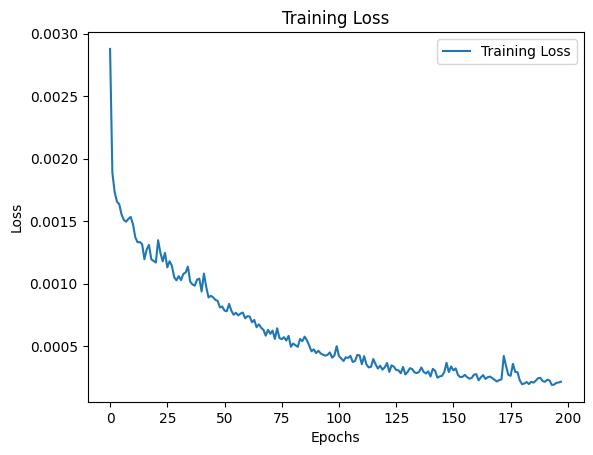

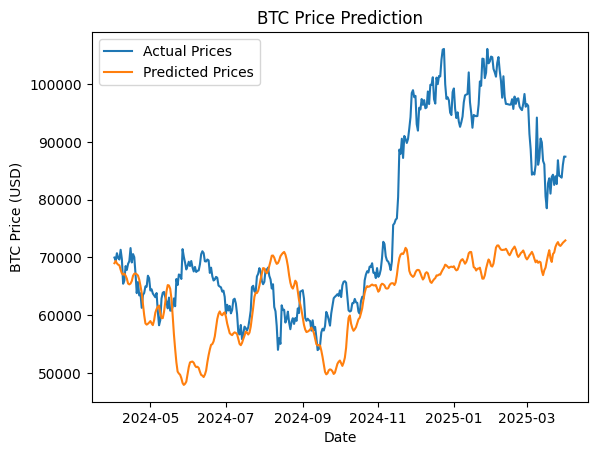

In [13]:
if loaded == None:
	plt.plot(train_losses[2:], label='Training Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Training Loss')
	plt.legend()
	plt.show()

plt.plot(test_dates, actuals[:, 0, 0], label='Actual Prices')
plt.plot(test_dates, predictions[:, 0, 0], label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()

Visualize sequence of outputs.

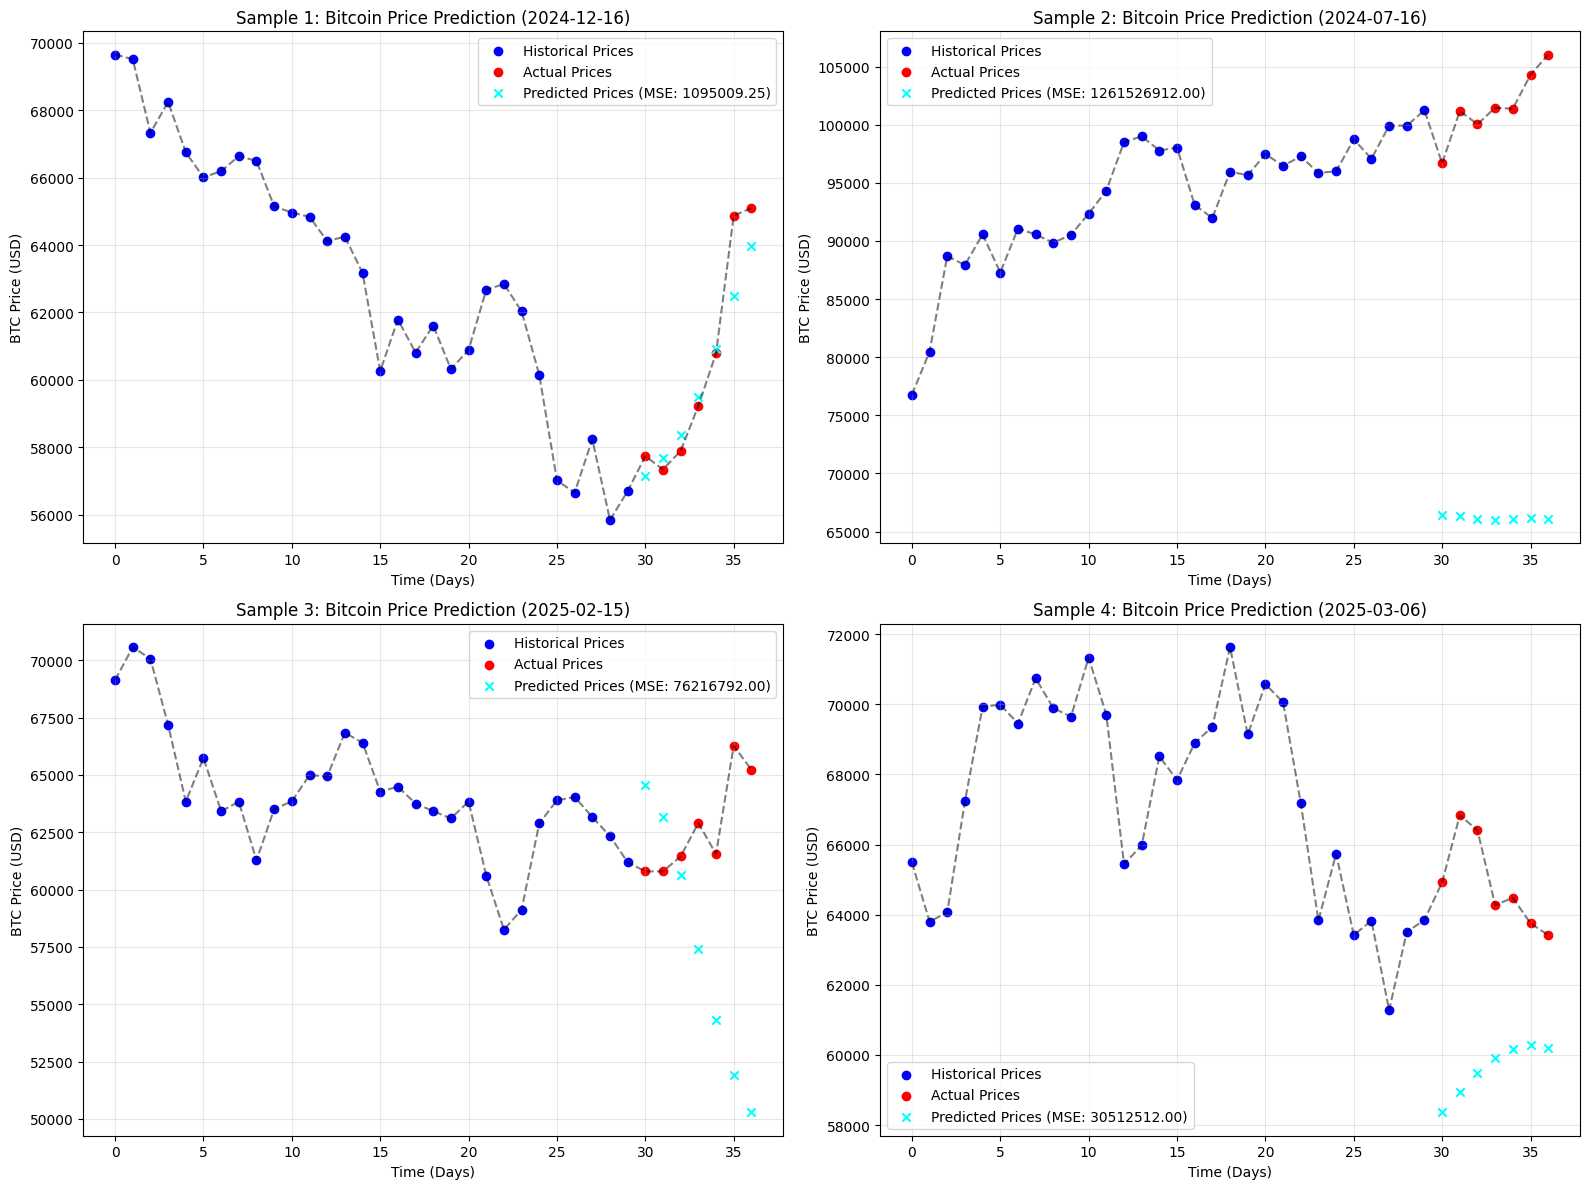

In [14]:
def visualize_bitcoin_predictions(model, test_dataset, n_samples=4):
	"""
	Visualizes predictions from the Bitcoin price prediction model using random samples
	"""
	model.eval()  # Set model to evaluation mode
	
	# Get total number of samples in test dataset
	total_samples = len(test_dataset)
	
	# Select random indices for visualization
	torch.manual_seed(0)
	np.random.seed(0)
	
	random_indices = np.random.choice(total_samples, size=n_samples, replace=False)
	
	# Create a grid of subplots
	fig, axs = plt.subplots(2, 2, figsize=(16, 12))
	axs = axs.flatten()
	
	for i, (ax, rand_idx) in enumerate(zip(axs, random_indices)):        
		with torch.no_grad():
			# Get the specific sample at the random index
			X_sample, y_truth = test_dataset[rand_idx]
			
			# Add batch dimension for model input
			X_batch = [x.unsqueeze(0).to(device) for x in X_sample]
			y_truth = y_truth.unsqueeze(0).to(device)
			
			# Forward pass through the model
			y_pred = model(X_batch, PREDICTION_LENGTH)
			
			# Get input data (open price from historical data)
			input_prices = y_scaler.inverse_transform(
				X_batch[0][0, :, 0].cpu().numpy().reshape(-1, 1)
			).flatten()
			
			# Get truth prices for the prediction period
			truth_prices = y_scaler.inverse_transform(
				y_truth[0].cpu().numpy().reshape(-1, 1)
			).flatten()
			
			# Get predicted prices
			pred_array = y_pred[0].detach().cpu().numpy()
			
			# Handle different output shapes properly
			if len(pred_array.shape) > 1:
				# For multi-dimensional output, take the first element of the last dimension
				if pred_array.shape[-1] > 1:
					pred_prices_raw = pred_array[:, 0].reshape(-1, 1)
				else:
					pred_prices_raw = pred_array.reshape(-1, 1)
			else:
				pred_prices_raw = pred_array.reshape(-1, 1)
				
			# Inverse transform to get original scale prices
			pred_prices = y_scaler.inverse_transform(pred_prices_raw).flatten()
			
			# Ensure we match dimensions
			min_len = min(len(truth_prices), len(pred_prices))
			truth_prices = truth_prices[:min_len]
			pred_prices = pred_prices[:min_len]
			
			# Create time indices
			input_times = list(range(len(input_prices)))
			pred_times = list(range(len(input_prices), len(input_prices) + min_len))
			
			# Calculate error
			mse = np.mean((truth_prices - pred_prices) ** 2)
			
			# Find the actual date for this sample
			sample_date = test_dates[rand_idx].strftime('%Y-%m-%d')
			
			# Plotting
			ax.scatter(input_times, input_prices, label="Historical Prices", color="blue")
			ax.scatter(pred_times, truth_prices, label="Actual Prices", color="red")
			ax.scatter(pred_times, pred_prices, label=f"Predicted Prices (MSE: {mse:.2f})", 
					  color="cyan", marker="x")
			
			# Connect the points with a line
			all_times = input_times + pred_times
			all_prices = np.concatenate([input_prices, truth_prices])
			ax.plot(all_times, all_prices, "k--", alpha=0.5)
			
			# Add labels and title
			ax.set_title(f"Sample {i+1}: Bitcoin Price Prediction ({sample_date})")
			ax.set_xlabel("Time (Days)")
			ax.set_ylabel("BTC Price (USD)")
			ax.legend(loc="best")
			ax.grid(True, alpha=0.3)
	
	plt.tight_layout()
	plt.show()

# Use the function with your dataset
visualize_bitcoin_predictions(model, test_dataset)